# Dog Breed Identification

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification

---

Welcome to the project of Dog Breed Identification! This project is based on the Dog Breed Classifier Project in the [Machine Learning Engineer Nanodegree at Udacity Online Course](https://eu.udacity.com/course/machine-learning-engineer-nanodegree--nd009).

This project is based to cover the state-of-the-art Convolutional Neural Nerworks (CNN) models for classification. Here, a pipeline to process real-world, user-supplied images is build. Given an image of a dog, the algorithm will identify an estimate of the canine's breed. If supplied an image of a human, the code will identify the resembling dog breed. 

The goal is that by completing this project, the challenges involved in piercing together s series of models designed to perform various tasks in a data processing pipeline is understood. Each model has its strengths and weaknesses, and engineering a real-world application often involves solving many problems without a perfect answer. The imperfect solution will nonetheless create a fun user experience!

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. 

### The Road Ahead

The notebook is separated into separate steps. Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write the Algorithm
* [Step 7](#step7): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, a dataset of dog images is imported. Few variables are populated through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob
import random
import cv2                
%matplotlib inline
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
from extract_bottleneck_features import *

# Import for sklearn
from sklearn.datasets import load_files   

# Import for keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, a dataset of human images is imported, where the file paths are stored in the numpy array `human_files`.

In [3]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, a demonstration on how to use this detector to find human faces and eyes in a sample image.

Number of faces detected (in blue): 1
Number of eyes detected (in green): 2


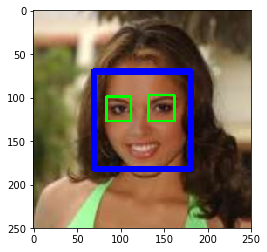

In [4]:
# extract pre-trained face and eye detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

# load color (BGR) image
img = cv2.imread(human_files[52])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces and eyes in image
faces = face_cascade.detectMultiScale(gray)

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image face
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)    
    
    # within the range of faces (roi_gray), we search for the eyes
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    # get bounding box for each detected eye
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

# print number of faces detected in the image
print('Number of faces detected (in blue):', len(faces))
print('Number of eyes detected (in green):', len(eyes))
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face or eyes detectors, it is standard procedure to convert the images to grayscale. The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

This procedure can be used to write a function that returns `True` if a human face is detected in an image and `False` otherwise. This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector

Ideally, 100% of human images is expected with a detected face and 0% of dog images with a detected face. But as the cell block below shows, the algorithm falls short of this goal, but still gives acceptable performances. The file's paths are extracted for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm 
# on the images in human_files_short and dog_files_short.
p_human = 0
p_dog = 0
for i in range(len(human_files_short)):
    if face_detector(human_files_short[i]):
        p_human += 1
    if face_detector(dog_files_short[i]):
        p_dog += 1
p_human = p_human/len(human_files_short)
p_dog = p_dog/len(dog_files_short)
print('human percentage: ', p_human)
print('dog percentage: ', p_dog)

human percentage:  0.98
dog percentage:  0.11


The percentage of the 1st 100 images in:
`human files` : 98%
`dog files` : 11%

This algorithmic choice necessitates to communicate to the user that only human images are accepted when they provide a clear view of a face (otherwise, there's a risk of having unneccessarily frustrated users!).

However, it is not a reasonable expectation to pose on the user. Indeed, other algorithm can be added in the model
that detect smaller parts of the face, such as the mouth, the eyes the nose or the ears. These algorithms can be added in the same way as the haarcascade_eye eye detection added above.
Thus, the haarcascade_eye is implemented above with the haarcascade_frontalface_alt algorithm.

But if, the model is left as such (without adding additional detectors from OpenCV's github), a clear view of a face can be imposed to the user.

The face detector from OpenCV is suggested as a potential way to detect human images in the algorithm, but other approaches can be explored, especially approaches that make use of deep learning. 

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images is used. The first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which is also refered to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since the images are colored images each image has three channels. Likewise, since a single iamge (or sample) is precessed, the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`. The code for `preprocess_input` is [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that a way to format the image for supplying to ResNet-50 is described, the use of the model to extract the predictions can be described. This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, an integer corresponding to the model's predicted object class is obtained. This predicted object class can be identified with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Writing a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), one can notice that  the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, one need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

These ideas are used to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assessing the Dog Detector


In [12]:
### Testing the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

p_human = 0
p_dog = 0
for i in range(len(human_files_short)):
    if dog_detector(img_path=dog_files_short[i]):
        p_dog += 1
    if dog_detector(img_path=human_files_short[i]):
        p_human += 1
print('human percentage: ', p_human/len(human_files_short))
print('dog percentage: ', p_dog/len(dog_files_short))

human percentage:  0.02
dog percentage:  1.0


The percentage of the images in `human_files_short` detected as dog is 2%.

The percentage of the images in `dog_files_short` detected as dog is 100%

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that the function for detecting humans and dogs in images is available, a way to predict breed from images is needed.

In this step, a CNN that classifies dog breeds is created. _Transfer Learning_ is not (_yet_!) used here. In step 5 of this notebook, transfer learning is used to create a CNN that attains greatly improved accuracy. 

This CNN in step 3 is created **from scratch**. The goal here is to attain a test accuracy of at least 1% (only!). 

Here, not too many tranable layers are added. Indeed, more parameters means longer training, which means a GPU is more likely to be needed to accelerate the training process. Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; this estimate can be extrapolated to figure out how long it will take for the algorithm to train.

As mentionned, the task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel

<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black. The vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador

<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 836/836 [00:05<00:00, 142.45it/s]


### Model Architecture

Here a CNN to classify dog breed is created. At the end of the code cell block, the layers of the model is summarized by the line:
    
        model.summary()

The model created below is based on the following image. It specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
The model above was used as a baseline. Convolutional layers and Max Pooling layers are effective here. Every layer in this network uses a relu activation, a stride of 1 and a 'same' padding.

Using a series of Convolutional layers with doubling each time the number of filters would enable the network to distinguish more and more complex patterns between the differents types of dog breeds. As the convolutional layers are locally connected, overfitting is reduced. 

As for the Pooling layers in between the conv layers, they are implemented in order to reduce the filters dimensionality. Indeed, the dimensionality of the convolutional layers increases and there are lots of filters.

The Global Average Pool enable to flatten the datas.

Fully connected dense layers at the end of the network enable the model to output a probability of an image belonging among the 133 dog breed. A dropout is implemented to the first dense layer in order to improve the accuracy and prevent overfitting.

Adam optimizer was chosen for this network, categorical_crossentropy for the loss function and accuracy as for the metrics.

In [14]:
model = Sequential()

### Define the architecture.
model.add(Conv2D(filters = 16, kernel_size = (2,2), strides = 1, activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = 1, padding = 'same'))
model.add(Conv2D(filters = 32, kernel_size = (2,2), strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = 1, padding = 'same'))
model.add(Conv2D(filters = 64, kernel_size = (2,2), strides = 1, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = 1, padding = 'same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(133, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 223, 223, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 223, 223, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 223, 223, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 223, 223, 64)      8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 223, 223, 64)      0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

The code cell below train the model. Model checkpointing is used to save the model that attains the best validation loss.

In [16]:
### Specified the number of epochs to use to train the model.

epochs = 5
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 1431s - loss: 4.8830 - acc: 0.0061 - val_loss: 4.8696 - val_acc: 0.0096
Epoch 2/5
6680/6680 [==============================] - 1436s - loss: 4.8696 - acc: 0.0123 - val_loss: 4.8609 - val_acc: 0.0144
Epoch 3/5
6680/6680 [==============================] - 1436s - loss: 4.8350 - acc: 0.0169 - val_loss: 4.8091 - val_acc: 0.0168
Epoch 4/5
6680/6680 [==============================] - 1432s - loss: 4.7718 - acc: 0.0196 - val_loss: 4.7618 - val_acc: 0.0240
Epoch 5/5
6680/6680 [==============================] - 1431s - loss: 4.7238 - acc: 0.0201 - val_loss: 4.7149 - val_acc: 0.0251


### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Testing the Model

Trying out the model on the test dataset of dog images. Recall that the goal is to attain at least 1% of accuracy.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.7943%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, training a CNN using transfer learning is shown here. 

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model. Only a global average pooling layer and a fully connected layer are added, where the latter contains one node for each dog category and is equipped with a softmax activation function.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compiling the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Training the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.6024 - acc: 0.1144 - val_loss: 11.1874 - val_acc: 0.1988
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.7720 - acc: 0.2543 - val_loss: 10.7548 - val_acc: 0.2419
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 10.2732 - acc: 0.3075 - val_loss: 10.4504 - val_acc: 0.2707
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.9607 - acc: 0.3404 - val_loss: 10.1215 - val_acc: 0.3150
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.7242 - acc: 0.3660 - val_loss: 10.1395 - val_acc: 0.3102
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.6153 - acc: 0.3799 - val_loss: 9.9986 - val_acc: 0.3090
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.4676 - acc: 0.3942 - val_loss: 9.8670 - val_acc: 0.3257
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 9.3

### Loading the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Testing the Model

Now, the CNN can be used to test how well it identifies breed within the test dataset of dog images. The test accuracy is printed below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.0718%


### Predict Dog Breed with the Model

In [25]:
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)    
    # return dog breed that is predicted by the model    
    return(dog_names[np.argmax(predicted_vector)])

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In this step, transfer learning is used to create a CNN that can identify dog breed from images. The goal of this section is to attain at least 60% accuracy on the test set. 

In Step 4, transfer learning is used to create a CNN using VGG-16 bottleneck features. In this section, a bottleneck features from a different pre-trained model is used. To make things easier, a pre-computed features for all the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`. 

### Obtain Bottleneck Features

In the code block below, the bottleneck picked here is **Xception bottleneck**. It is then downloaded and stored in the `bottleneck_features/` folder in the repository.

In [26]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
test_Xception = bottleneck_features['test']
valid_Xception = bottleneck_features['valid']

###  Model Architecture

All 4 differents networks (VGG-19, Resnet50, InceptionV3 and Xception) were tested before chosing the final model to used. The Xception architecture was chosen because it performed at more than 80% of accuracy. This architecture is suitable to this project as Xception bottlneck features is designed for image classification based on ImageNet's weights. This is the reason why, the VGG-16 model and the model from scratch didn't perform that well around 40% and 2% respectively. 

Because of Xception is designed for image classification, no other layer other than the final Dense layer output with a softmax activation function is added.

At the end of the code cell block, the layers of the model is summarized by executing the line:
    
        <the model's name>.summary()

In [27]:
### Defining the architecture.
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape = train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compiling the Model

In [28]:
### Compiling the model.
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Training the Model

The chosen model is trained in the code cell below. The model checkpointing is used to save the model that attains the best validation loss.

In [29]:
### Training the model.
epochs = 10
batch_size = 20

### Training without augmentation
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 3s - loss: 1.0536 - acc: 0.7373 - val_loss: 0.5064 - val_acc: 0.8383
Epoch 2/10
6680/6680 [==============================] - 2s - loss: 0.3965 - acc: 0.8701 - val_loss: 0.4803 - val_acc: 0.8479
Epoch 3/10
6680/6680 [==============================] - 3s - loss: 0.3265 - acc: 0.8945 - val_loss: 0.4873 - val_acc: 0.8479
Epoch 4/10
6680/6680 [==============================] - 2s - loss: 0.2771 - acc: 0.9123 - val_loss: 0.5007 - val_acc: 0.8515
Epoch 5/10
6680/6680 [==============================] - 3s - loss: 0.2425 - acc: 0.9232 - val_loss: 0.5371 - val_acc: 0.8539
Epoch 6/10
6680/6680 [==============================] - 2s - loss: 0.2206 - acc: 0.9335 - val_loss: 0.5222 - val_acc: 0.8575
Epoch 7/10
6680/6680 [==============================] - 3s - loss: 0.1987 - acc: 0.9388 - val_loss: 0.5561 - val_acc: 0.8563
Epoch 8/10
6680/6680 [==============================] - 2s - loss: 0.1741 - ac

"\ndatagen = ImageDataGenerator(width_shift_range=0.1, rotation_range=20, horizontal_flip = True)\n\ntrain_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, rotation_range=20,\n                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True)\n\ntest_datagen = ImageDataGenerator(rescale=1./255)\n\ntrain_generator = train_datagen.flow_from_directory('dogImages/train',target_size=(7,7),batch_size=batch_size)\n\nvalid_generator = train_datagen.flow_from_directory('dogImages/valid',target_size=(7,7),batch_size=batch_size)\n\nbottleneck_features_train = vgg19_model.predict_generator(train_generator, len(train_files)//batch_size)\n\nbottleneck_features_valid = vgg19_model.predict_generator(valid_generator, len(valid_files)//batch_size)\n\ntrain_labels = np.array([0]*int(len(train_files)/2) + [1]*int(len(train_files)/2))\n\nvalid_labels = np.array([0]*int(len(valid_files)/2) + [1]*int(len(valid_files)/2) + [2]*int(len(valid_files)/2) +[3]*int(len(vali

### Loading the Model with the Best Validation Loss

In [30]:
### Loading the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Testing the Model

The model is tested on the test dataset of dog images. The goal of this section is to attain an accuracy greater than 60% on the test set.

In [31]:
### Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 85.2871%


### Predict Dog Breed with the Model

The function below takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by the model.

Similar to the analogous function in Step 5, the function have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. To obtain the bottleneck features corresponding to the chosen CNN architecture, the following function needs to be used:

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [32]:
### Function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Xception_predict_breed(img_path, dog_names = dog_names):
    # Extracts Xception architecture 
    bottleneck_features = extract_Xception(path_to_tensor(img_path))
    
    # get a vector of predicted dog breed's index for the image
    predicted_vector = Xception_model.predict(bottleneck_features)
    
    # get the index of the highest probability in the vector and its prbability
    highest = np.argmax(predicted_vector)
    p_highest = predicted_vector[0][highest]
    
    # get the index of the 2nd highest probability in the vector and its probability
    highest_2nd = np.argsort(-predicted_vector)[0][:2][1]  
    p_highest_2nd = predicted_vector[0][highest_2nd]
    
    # We check if the difference between the 2 highest probability is lower than 10% (arbitrary)
    # if so there would be 2 dog names will output
    if (p_highest - p_highest_2nd) < 0.1:
        return(dog_names[highest], dog_names[highest_2nd])
    # if not, only one dog name will output
    else:
        return(dog_names[highest])


In [33]:
Xception_predict_breed('dogImages/test/016.Beagle/Beagle_01130.jpg')

'Beagle'

---
<a id='step6'></a>
## Step 6: Writing the Algorithm

The function below accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,

- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

`face_detector` and `dog_detector` functions developed above are used in this function as well as the CNN from Step 5 to predict dog breed. 

Some sample output for our algorithm is provided below.

![Sample Human Output](images/sample_human_output.png)


### Writing the Algorithm

In [34]:
### Writing the algorithm.
def prediction_breed(img_path):
    img = cv2.imread(img_path)
    if face_detector(img_path) == True:
        print('Hello Human!')
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print('You look like a ... \n')
        print(Xception_predict_breed(img_path))
    elif dog_detector(img_path) == True:
        print('Hello Dog!')
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print('You look like a ... \n')
        print(Xception_predict_breed(img_path))
    else:
        print('This picture is neither a Human nor a Dog.')

Hello Human!


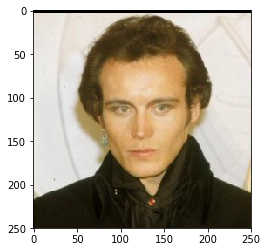

You look like a ... 

('Dachshund', 'Anatolian_shepherd_dog')


In [35]:
prediction_breed('lfw/Adam_Ant/Adam_Ant_0001.jpg')

---
<a id='step7'></a>
## Step 7: Testing the Algorithm

The new algorithm is taken in another step.

What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?


### Testing the Algorithm on Sample Images!

The algorithm is tested at at least 6 images on the computer. Feel free to use any images.

Here, two images of human, two images of dogs and two images of non-human and non-dog are used. 

This picture is neither a Human nor a Dog.
Hello Human!


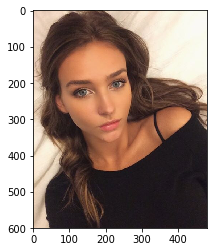

You look like a ... 

('Chinese_crested', 'Anatolian_shepherd_dog')
Hello Dog!


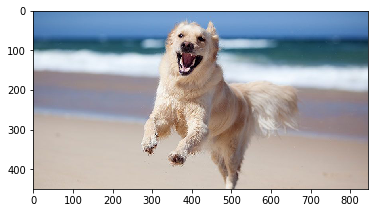

You look like a ... 

Anatolian_shepherd_dog
Hello Dog!


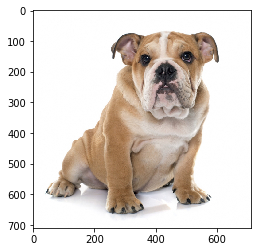

You look like a ... 

Bulldog
This picture is neither a Human nor a Dog.
This picture is neither a Human nor a Dog.


In [36]:
## Executing the algorithm from Step 6

# Human prediction
prediction_breed('images/Human1.jpg')
prediction_breed('images/Human2.jpg')

# Dog prediction
prediction_breed('images/Dog1.jpg')
prediction_breed('images/Dog2.jpg')

# Other things prediction
prediction_breed('images/None1.jpg')
prediction_breed('images/None2.jpg')

The first human picture wasn't recognize as a human. Probably because the face of the person is partially hidden and our face recognition could be improved. The other pictures were correctly classified as dog, human or none. 

We can improve on the face recognition on human, change the optimizer maybe or improve our architecture.